# Similarity Score Implementation

•Will use percentiles on key variables.

For this sprint stories, will apply the [`Histogram Intersection` method](https://mpatacchiola.github.io/blog/2016/11/12/the-simplest-classifier-histogram-intersection.html), adjusted to compare relative instead of absolute frequencies. Similarity score will be the normalize intersection coefficient, Intersection(H1, H2) = Σ min(h1i, h2i) where hij are the relative frequencies in the bins.

•Variables: MVP is effective Tax paid and deduct to income ratio. Post additional to add in the first place are the annual changes in the effective tax paid and deduct to income ratio. Then, the main deductions and their annual variation.

•Time horizon: 4 years, customizable (parameter)

•Will take out the time variation by using percentiles of single variables, and their histograms using 8 bins, which will have the same edges for all firms.

Post MVP, will cluster audits and compare histograms using the Chi-square test as the main test. Will also implement Kolmogorov-Smirnov tests since it is helpful for differences in the tails.

Post MVP similarity score will be the p-value of the Chi-square test.# Similarity Score Implementation
Summary: we will compare how close are the histograms between unlabeled data and audits



In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from dstools.mlutils.corp_tax_audit_unsupervised import (
        histogram_intersection,
        generate_bin_edges,
        similarity_score, 
        similarity_scores
        )

In [2]:
# Generating bins with n_edges
def generate_bin_edges_local(n_bins, start, end):
    """
    Generate the edges of equally spaced bins.

    Parameters:
        - n_bins (int): The number of bins.
        - start (float): The starting point of the bin range.
        - end (float): The ending point of the bin range.

    Returns:
        - bin_edges (numpy.ndarray): The edges of the generated bins.
    """
    bin_width = (end - start) / n_bins
    bin_edges = np.linspace(start, end, num=n_bins+1)
    return bin_edges

In [3]:
def histogram_intersection_local(hist1, hist2):
    """
    Calculate the intersection between two histograms using the Histogram Intersection method.
    It is use as a technique of similarity.

    Parameters:
        hist1 (array-like): Array-like object representing the values of the first histogram.
        hist2 (array-like): Array-like object representing the values of the second histogram.

    Returns:
        float: Intersection value between the two histograms.

    Example:
        hist1 = [0.05, 0.06, 0.09, 0.12, 0.17, 0.23, 0.31, 0.31, 0.43, 0.45, 0.52, 0.59, 0.87, 0.89, 0.93, 0.94]
        hist2 = [0.06, 0.07, 0.1, 0.12, 0.16, 0.23, 0.3, 0.32, 0.44, 0.43, 0.51, 0.58, 0.88, 0.9, 0.93, 0.92]
        intersection = histogram_intersection(hist1, hist2)
        print(intersection)
    """
    minima = np.minimum(hist1, hist2)
    intersection = np.sum(minima)
    return intersection

# Loading data

In [4]:
set_of_features = ['tax_rate_percentile_peers']
ref_cols = ['naics_code', 'business_id', 'bus_loc_id', 'business_legal_name']

# UNLABELED
%store -r X_m_plot_42
sample_data = X_m_plot_42
sample_data = sample_data[['date'] + ref_cols + set_of_features + ['k-cluster']]
sample_data['k-cluster'].value_counts()
unlabel_cluster1_data = sample_data[sample_data['k-cluster']==1]
unlabel_cluster1_data.head()

,date,naics_code,business_id,bus_loc_id,business_legal_name,tax_rate_percentile_peers,k-cluster
184,2011Q3,423210,577394,583446,ALCHEMY INTERNATIONAL CORP,0.216216,1
185,2011Q4,423210,577394,583446,ALCHEMY INTERNATIONAL CORP,0.210526,1
186,2012Q1,423210,577394,583446,ALCHEMY INTERNATIONAL CORP,0.121212,1
187,2012Q2,423210,577394,583446,ALCHEMY INTERNATIONAL CORP,0.200000,1
191,2013Q2,423210,577394,583446,ALCHEMY INTERNATIONAL CORP,0.218750,1


In [5]:
# AUDITS
# Data merged audits with unlabel data to calculate percentiles of the audits in relation to the overall data
%store -r audit_data_percentile_42
audit_data_percentiles = audit_data_percentile_42

pos_change_audit_data = audit_data_percentiles[audit_data_percentiles['change+']==True][['business_id', 'effective_period_tax_percentage_rate_paid_percentile_peers']]


## Similarity score Function for One Pair of Percentiles

In [8]:
# Auxiliar function for the calculation of individual pairs
def similarity_score_local(percentiles_unlabel: pd.Series, percentiles_audit: pd.Series, 
                           nbins: int = 8, 
                           method="histogram_intersection"):  
    """
    Auxiliar function to compute the similarity score between two sets of percentiles 
    using the Histogram Intersection method, which is the only one implemented in this moment.
    
    The function starts by generating bin edges, which creates equally spaced bins based on
    the specified nbins.

    The percentiles arrays (percentiles_unlabel and percentiles_audit) are sorted in
    ascending order using np.sort to ensure consistent ordering.

    The values in each percentiles array are counted in their respective bins.

    Histograms of relative frequency are created for both the unlabeled and audit data. 

    If the specified method is "histogram_intersection," the similarity score is calculated using
    the histogram_intersection function, passing the histogram of relative frequencies for the
    unlabeled and audit data.

    Parameters:
        percentiles_unlabel (pd.Series): Array-like object containing the percentiles of the unlabeled data.
        percentiles_audit (pd.Series): Array-like object containing the percentiles of the audit data.
        nbins (int, optional): Number of bins for histogram calculation. Defaults to 8.
        method (str, optional): Similarity score calculation method. Defaults to "histogram_intersection".

    Returns:
        A dictionary with the following components:
            - 'similarity_score' (float): Similarity score between the two sets of percentiles.
            - 'freq_unlabel' (ndarray): Frequency counts of unlabeled data in each bin.
            - 'freq_audit' (ndarray): Frequency counts of audit data in each bin.
            - 'bin_edges_unlabel': the limits of each bin (intervals of the unlabel histogram)
            - 'bin_edges_audit': the limits of each bin (intervals of the unlabel histogram)
            - 'hist_rel_unlabel' (ndarray): Histogram of relative frequency for unlabeled data.
            - 'hist_rel_audit' (ndarray): Histogram of relative frequency for audit data.
            
        Obs: 'bin_edges_unlabel' and 'bin_edges_audit' must be the same.

    Raises:
        ValueError: If the specified method is not supported.

    Example:
        percentiles_unlabel = pd.Series([0.2, 0.5, 0.3, 0.1, 0.4])
        percentiles_audit = pd.Series([0.1, 0.3, 0.4, 0.2, 0.6])

        score_result = similarity_score(percentiles_unlabel, percentiles_audit)
        similarity_score = score_result['similarity_score']

        print(similarity_score)

    """
    bin_edges = generate_bin_edges(nbins, start=0, end=1)
    
    # Sort percentiles arrays
    percentiles_unlabel = np.sort(percentiles_unlabel)
    percentiles_audit = np.sort(percentiles_audit)

    
    # Counting values in each bin
    bin_counts_unlabel = np.digitize(percentiles_unlabel, bin_edges) - 1
    bin_counts_audit = np.digitize(percentiles_audit, bin_edges) - 1

    
    # Creating histograms of relative frequency. 
    # Handling division by zero with all frequencies = 0.
    freq_unlabel = np.histogram(percentiles_unlabel, bins=bin_edges)
    if freq_unlabel[0].sum() == 0:
        hist_rel_unlabel = [0]*nbins
    else:         
        hist_rel_unlabel = freq_unlabel[0]/freq_unlabel[0].sum()
    
    
    freq_audit = np.histogram(percentiles_audit, bins=bin_edges)  
    if freq_audit[0].sum() == 0:
        hist_rel_audit=[0]*nbins
    else:
        hist_rel_audit = freq_audit[0]/freq_audit[0].sum()
    
    if method == "histogram_intersection":
        similarity_score = histogram_intersection(hist_rel_unlabel, hist_rel_audit)
    else:
        logging.error("Method not supported. Only 'histogram_intersection' is implemented.")
        raise ValueError("Method not supported. Only 'histogram_intersection' is implemented.")
    
    return {'similarity_score': similarity_score, 
            'freq_unlabel': freq_unlabel[0],
            'freq_audit': freq_audit[0],
            'bin_edges_unlabel': freq_unlabel[1],
            'bin_edges_audit': freq_audit[1],
            'hist_rel_unlabel': hist_rel_unlabel,
            'hist_rel_audit':hist_rel_audit
           }

In [6]:
# Sample data for simple pair similarity score
audit_ids = pos_changes = pos_change_audit_data['business_id'].unique()
unlabel_ids = unlabel_cluster1_data['business_id'].unique()
audit_sample = pos_change_audit_data[pos_change_audit_data['business_id']==audit_ids[1]]['effective_period_tax_percentage_rate_paid_percentile_peers']
unlabel_sample = unlabel_cluster1_data[unlabel_cluster1_data['business_id']==unlabel_ids[1]]['tax_rate_percentile_peers']

In [7]:
# Similarity Score simple pair output
sim_score_results = similarity_score(percentiles_unlabel = unlabel_sample, 
                                    percentiles_audit = audit_sample, 
                                    nbins=8)
sim_score_results

{'similarity_score': 0.5,
 'freq_unlabel': array([4, 4, 0, 0, 0, 0, 0, 0]),
 'freq_audit': array([ 0, 10,  7,  0,  0,  0,  0,  0]),
 'bin_edges_unlabel': array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
 'bin_edges_audit': array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]),
 'hist_rel_unlabel': array([0.5, 0.5, 0. , 0. , 0. , 0. , 0. , 0. ]),
 'hist_rel_audit': array([0.        , 0.58823529, 0.41176471, 0.        , 0.        ,
        0.        , 0.        , 0.        ])}

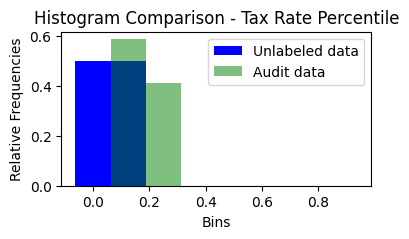

In [8]:
# PLOT PAIR COMPARISON RESULTS - interpretation of histogram comparison
bin_edges = sim_score_results['bin_edges_unlabel']
frequencies1 = sim_score_results['hist_rel_unlabel']
frequencies2 = sim_score_results['hist_rel_audit']

# Plot bar plot
plt.figure(figsize=(4, 2))
plt.bar(bin_edges[:-1], frequencies1, width=np.diff(bin_edges), color='blue', label='Unlabeled data')
plt.bar(bin_edges[:-1], frequencies2, width=np.diff(bin_edges), color='green', label='Audit data', alpha=0.5)

# Set labels and title
plt.xlabel('Bins')
plt.ylabel('Relative Frequencies')
plt.title('Histogram Comparison - Tax Rate Percentile')

# Add legend and size
plt.legend()

# Show the plot
plt.show()

# Similarity Scores Function for a full dataset of data

In [17]:
def similarity_scores(percentiles_unlabel: pd.DataFrame, 
                      percentiles_audit: pd.DataFrame,
                      unlabel_percentile_col: str,
                      audit_percentile_col: str,
                      key: str = 'business_id',
                      nbins: int = 8, 
                      method: str = "histogram_intersection",
                      percentile_threshold: int = 90,
                      sort_values: bool = True
                     ):
    """
    Calculate the similarity scores between unlabeled and audit data, for several business_id for 
    the unlabel data, and several audits as well.
    
    Parameters:
        percentiles_unlabel (DataFrame): DataFrame containing the unlabeled data and their corresponding percentiles.
            The DataFrame must have a key, per default 'business_id'.
        percentiles_audit (DataFrame): DataFrame containing the audit data and their corresponding percentiles.
            The DataFrame must have a key, per default 'business_id'.
        unlabel_percentile_col (str): Column name for the unlabeled percentiles in the percentiles_unlabel dataframe.
        audit_percentile_col (str): Column name for the audit percentiles in the percentiles_audit dataframe.
        nbins (int, optional): Number of bins for histogram calculation. Defaults to 8.
        method (str, optional): Similarity score calculation method. Defaults to "histogram_intersection".
        percentile_threshold (float, optional): Threshold percentile for counting similarity scores. Defaults to 90.
        sort_values (bool, optional): Whether to sort the similarity scores in descending order. Defaults to True.

    Returns:
        Dict: A dictionary containing the following information:
            - 'similarity_df' (pd.DataFrame): Pandas DataFrame with unlabeled IDs as index and audit IDs as columns,
                filled with similarity scores, maximum similarity score (nbins), audit ID with maximum score,
                count above threshold column, and sorted maximum similarity score and count above threshold
                if sort_values is True.
            - 'nbins' (int): The number of bins used for similarity calculation.
            - 'thresholds[similarity, percentile]' (list): List containing the similarity threshold and
                 the corresponding percentile threshold associated to it.
            - 'unlabel_percentile_col' (str): The column name for unlabelled percentile values.
            - 'audit_percentile_col' (str): The column name for audit percentile values.
            - 'method' (str): The method used to calculate similarity.

    Example:
        similarity_df = similarity_scores(percentiles_unlabel, percentiles_audit)
        print(similarity_df)
    """
    unlabel_ids = percentiles_unlabel['business_id'].unique().astype(str)
    audit_ids = percentiles_audit['business_id'].unique().astype(str)
    
    similarity_df = pd.DataFrame(index=unlabel_ids, columns=audit_ids)

    for unlabel in unlabel_ids:
        max_score = -1  # Initialize maximum score
        #second_best_score = -1  
        max_column = None  # Initialize column name with maximum score
        #second_best_column = None 

        
        for audit in audit_ids:
            
            percentiles_unlabel_data = percentiles_unlabel[percentiles_unlabel['business_id'].astype(str) == unlabel][unlabel_percentile_col]
            percentiles_audit_data = percentiles_audit[percentiles_audit['business_id'].astype(str) == audit][audit_percentile_col]
            
            score = similarity_score(percentiles_unlabel_data, percentiles_audit_data, nbins, method)['similarity_score']
            similarity_df.loc[unlabel, audit] = score
            

            # Update maximum score and corresponding column name
            if score > max_score:
                max_score = score
                max_column = audit
        
        # Add columns for maximum score and column name
        max_sim_score_col_name = 'max_sim_score'
        similarity_df.loc[unlabel, max_sim_score_col_name] = max_score
        similarity_df.loc[unlabel, 'audit_id_max'] = max_column

    
    # nanpercentile function handles missing values by excluding them
    similarity_threshold = np.percentile(similarity_df.loc[:, audit_ids], percentile_threshold, overwrite_input=False)
    count_above_threshold = similarity_df.apply(lambda row: sum(row[audit_ids] > similarity_threshold), axis=1)
    threshold_col_name = ">similarity_threshold"
    similarity_df[threshold_col_name] = count_above_threshold

    # Reorder the columns to place audit IDs at the end
    column_order = [max_sim_score_col_name, 'audit_id_max',threshold_col_name] + list(audit_ids)
    similarity_df = similarity_df.reindex(columns=column_order)
    
    if sort_values:
        similarity_df.sort_values(by=[max_sim_score_col_name, threshold_col_name], ascending=False, inplace=True)
        
    # Add label row and column
    similarity_df.columns.name = 'Stats and Audit IDs->'
    similarity_df.index.name = 'Unlabeled IDs'
        
    return  {
        'similarity_df': similarity_df,
        'nbins': nbins,
        'thresholds': [similarity_threshold, percentile_threshold, '[similarity, percentile]'],
        'unlabel_percentile_col': unlabel_percentile_col,
        'audit_percentile_col': audit_percentile_col,
        'method': method
    }


In [10]:
# Similarity Score main function output (full dataset)
sim_scores_results = similarity_scores(percentiles_unlabel=unlabel_cluster1_data, 
                  percentiles_audit=pos_change_audit_data, 
                  nbins=8, 
                  unlabel_percentile_col='tax_rate_percentile_peers',
                  audit_percentile_col='effective_period_tax_percentage_rate_paid_percentile_peers',
                  method="histogram_intersection", 
                  percentile_threshold=95)

print(f" Thresholds: {sim_scores_results['thresholds']}\n")
sim_scores_results['similarity_df']

 Thresholds: [0.8429621848739496, 95, '[similarity, percentile]']



Stats and Audit IDs->,max_sim_score,audit_id_max,>similarity_threshold,563499,543946,20154,146728
Unlabeled IDs,,,,,,,
5772,0.981618,20154,1,0.0,0.294118,0.981618,0.294118
146728,0.972740,543946,1,0.33689,0.97274,0.3125,0.761836
518781,0.931373,146728,1,0.166667,0.754902,0.3125,0.931373
2270,0.927500,20154,1,0.0,0.24,0.9275,0.24
16677,0.926471,146728,1,0.25,0.838235,0.3125,0.926471
547961,0.869969,146728,1,0.105263,0.693498,0.3125,0.869969
43503,0.857143,543946,1,0.428571,0.857143,0.3125,0.806723
1866,0.836149,20154,0,0.013514,0.162162,0.836149,0.162162
114167,0.818182,146728,0,0.090909,0.679144,0.494318,0.818182
